# Introduction


**ASSIGNMENT DEADLINE: 27 Oct 2020 17:00**

In this assignemnt, the task is to implement some basic components for training convolutional neural network (CNN) over the MNIST dataset and recurrent neural network (RNN) over the NLTK dataset. You need to follow the lecture notes to 
- implement img2col function in [nn/operators.py](nn/operators.py)
- implement the backward function of conv operation in [nn/operators.py](nn/operators.py), which are used by the Conv2D in [nn/layers.py](nn/layers.py)
- implement the forward function of pool operation in [nn/operators.py](nn/operators.py), which are used by the Pool2D in [nn/layers.py](nn/layers.py)
- implement the forward function of lstm operation in [nn/operators.py](nn/operators.py), which are used by the LSTMCell in [nn/layers.py](nn/layers.py)
- implement the backward function of Bi-directional RNN in [nn/layers.py](nn/layers.py)
- tune the model architecture and some hyperparameters to improve the accuracy.

**Attention**:
- To run this Jupyter notebook, you need to install the dependent libraries as stated in [README.MD](README.MD). You do not need and should not use other libraries (like tensorflow and pytorch) in your code. The major version of Python should be 3. The tensorflow version should be after 2.2.0.
- You do not need a GPU for this assignment. CPU is enough.
- Do not run this notebook before you finish the implementation of the required functions. otherwise, you will see errors as this notebook will call the functions to be implemented by you.
- Do not change the signature (the name and arguments) of the existing functions in the repository ; otherwise your implementation cannot be tested correctly and you will get penalty.
- Do not change the structure of files in the repository (e.g., adding, renaming or deleting any files); otherwise your implementation cannot be tested correctly and you will get penalty.
- You can add functions in the existing files, but you should not change the import statements (e.g., adding a new import statement). For example, if you want to implement a function foo(), you can implement it inside operator.py and call it; but you cannot implement it in another file and import that file in operators.py. Otherwise your implementation cannot be tested correctly and you will get penalty.
- After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.

In [10]:
a = [1,2,3]
b = [2,3,4]
c = []
c.append(a)
c.append(b)

c =np.array(c)
print(c)
print(c.shape)
c = c.transpose()
print(c)
print(c.shape)

[[1 2 3]
 [2 3 4]]
(2, 3)
[[1 2]
 [2 3]
 [3 4]]
(3, 2)


## Structure of the repository

The structure of this repository is shown as below:

```bash
codes/
    data/
        datasets.py     # load dataset, like MNIST
        mnist.npz       # mnist dataset 
        corpus.csv      # for nltk dataset 
        dictionary.csv  # for nltk dataset
    models/             # example models of your tiny deep learning framework
        MNISTNet.py     # example model on MNIST dataset
        SentimentNet.py # example model on nltk dataset
    nn/                 # components of neural networks
        operators.py    # operators; **You need to edit this file to add missing code**
        optimizers.py   # optimizing methods;
        layers.py       # layer abstract for CNN and RNN **You need to edit this file to add missing code**
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        funtional.py    # some helpful function
    utils/              # some additional tools for CNN
        check_grads_cnn.py  # for CNN, help you check your forward function and backward function
        check_grads_rnn.py  # for RNN, help you check your forward function and backward function
        tools.py        # other useful functions for testing the codes
    main.ipynb          # this notebook which calls the functions in other modules/files
    README.MD           # list of dependent libraries
```

## Functionality of this notebook

This iPython notebook serves to:

- explain code structure, main APIs
- explain your implementation task and tuning task
- provide code to test your implemented forward and backward function for different operations
- provide related materials to help you understand the implementation of some operations and optimizers

*You can type `jupyter lab` in the terminal to start this jupyter notebook when your current working directory is cs5242. It's much more convinient than jupyter notebook.*

# Your tasks for CNN

## Covolution layer

Conv2D (in [nn/layers.py](nn/layers.py)) implements the Convolution layer. It maintains the weight matrix and bias vector, and calls the forward and backward funtion of `conv` class in [nn/operators.py](nn/operators.py) to do the real operations. 


```python
class Conv2D(Layer):
    def __init__(self, conv_params, initializer=Gaussian(), name='conv'):
        super(Conv2D, self).__init__(name=name)
        self.conv_params = conv_params
        self.conv = conv(conv_params)

        self.trainable = True

        self.weights = initializer.initialize(
            (conv_params['out_channel'], conv_params['in_channel'], conv_params['kernel_h'], conv_params['kernel_w']))
        self.bias = np.zeros((conv_params['out_channel']))

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)

    def forward(self, input):
        output = self.conv.forward(input, self.weights, self.bias)
        return output

    def backward(self, out_grad, input):
        in_grad, self.w_grad, self.b_grad = self.conv.backward(
            out_grad, input, self.weights, self.bias)
        return in_grad

```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The total number of 0s to be added along the height (or width) dimension; half of the 0s are added on the top (or left) and half at the bottom (or right). we will only test even numbers.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class, used to initialize parameters


### img2col function

You need to implement img2col function in [nn/operators.py](nn/operators.py). img2col convert convolution operation into a matrix product, which can be found in lecture slides.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Conv2D
from utils.tools import rel_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D as k_Conv2D

input = np.random.uniform(size=(10, 3, 30, 30))
keras_input = input.transpose(0,2,3,1)
params = { 
    'kernel_h': 4,
    'kernel_w': 4,
    'pad': 2,
    'stride': 2,
    'in_channel': input.shape[1],
    'out_channel': 64,
}
conv = Conv2D(params)
out = conv.forward(input)

keras_conv = Sequential([
    k_Conv2D(filters=params['out_channel'],
            kernel_size=(params['kernel_h'], params['kernel_w']),
            strides=(params['stride'], params['stride']),
            padding='same',
            data_format='channels_last',
            input_shape=keras_input.shape[1:]),
])

keras_conv.layers[0].set_weights([conv.weights.transpose(2,3,1,0), conv.bias])

keras_out = keras_conv.predict(keras_input, batch_size=input.shape[0])

print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out.transpose(0,3,1,2)))

Relative error (<1e-6 will be fine):  2.482305620773316e-07


### Backward function of conv operator
 
You need to implement the backward function for the `conv` class in the file [nn/operators.py](nn/operators.py). 

When you are done, restart jupyter notebook and run the following to check your backward implementation. 

In [1]:
from nn.layers import Conv2D
import numpy as np
from utils.check_grads_cnn import check_grads_layer

batch = 10
conv_params={
    'kernel_h': 3,
    'kernel_w': 3,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']

input = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
out_grad = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))

conv = Conv2D(conv_params)
check_grads_layer(conv, input, out_grad)

D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\utils\check_grads_cnn.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = layer.forward(inputs).copy()
D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\utils\check_grads_cnn.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  neg = layer.forward(inputs).copy()


Gradient to input: correct


D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\utils\check_grads_cnn.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = layer.forward(inputs).copy()
D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\utils\check_grads_cnn.py:41: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  neg = layer.forward(inputs).copy()
D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\utils\check_grads_cnn.py:52: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = layer.forward(inputs).co

Gradient to weights:  correct
Gradient to bias:  correct


## Pooling layer

Pool2D (in nn/layers.py) implements the pooling layer. It calls the forward and backward funtion of the pool class in nn/operators.py to do the real operations. 

The initialization, forward and backward funtion of the class `Pooling` are shown as below:

```python
class Pool2D(Layer):
    def __init__(self, pool_params, name='pooling'):
        super(Pool2D, self).__init__(name=name)
        self.pool_params = pool_params
        self.pool = pool(pool_params)

    def forward(self, input):
        output = self.pool.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.pool.backward(out_grad, input)
        return in_grad
```

`pool_params` is a dictionary, containing these parameters:
- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The total number of 0s to be added along the height (or width) dimension; half of the 0s are added on the top (or left) and half at the bottom (or right). we will only test even numbers.

### Forward function of pool operator

You need to implement the forward function for `pool` class in the file [nn/operators.py](nn/operators.py).

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [5]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Pool2D
from utils.tools import rel_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D

input = np.random.uniform(size=(10, 3, 30, 30))
keras_input = input.transpose(0,2,3,1)
params = { 
    'pool_type': 'max',
    'pool_height': 4,
    'pool_width': 4,
    'pad': 2,
    'stride': 2,
}
pool = Pool2D(params)
out = pool.forward(input)

keras_pool = Sequential([
    MaxPooling2D(pool_size=(params['pool_height'], params['pool_width']),
                 strides=params['stride'],
                 padding='same',
                 data_format='channels_last',
                 input_shape=keras_input.shape[1:])
])
keras_out = keras_pool.predict(keras_input, batch_size=input.shape[0])

print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out.transpose(0,3,1,2)))

Relative error (<1e-6 will be fine):  7.971685122533327e-09


## Classification using CNNs
In this section, you are required to test your implementations above by running an CNN on a MNIST dataset. The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

We have provided you with [models/MNISTNet.py](models/MNISTNet.py), which defines a CNN model for this task. By training the `MNISTNet` for one epoch, you should achieve above 85% on test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


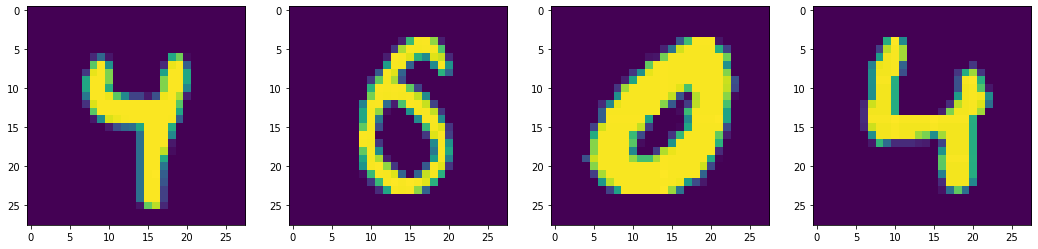

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from models.MNISTNet import MNISTNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from data.datasets import MNIST
np.random.seed(5242)

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [4]:
from nn.optimizers import RMSprop, Adam

model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.001, decay=0,  sheduler_func=None, bias_correction=True)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)

import time
start = time.time()
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=50, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=-1, test_intervals=900, print_intervals=100)
print('cost:', time.time()-start)

Epoch 0: 


D:\NUS sem1\CS5242 NNDL\Assignments\CS5242_Assignment2\nn\model.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  layer_inputs = layer.forward(layer_inputs)


Train iter 100/960:	acc 0.10, loss 2.30, reg loss 0.00, speed 15.01 samples/sec
Train iter 200/960:	acc 0.12, loss 2.27, reg loss 0.00, speed 15.08 samples/sec
Train iter 300/960:	acc 0.66, loss 1.03, reg loss 0.02, speed 14.98 samples/sec
Train iter 400/960:	acc 0.80, loss 0.56, reg loss 0.02, speed 15.31 samples/sec
Train iter 500/960:	acc 0.88, loss 0.62, reg loss 0.02, speed 15.17 samples/sec
Train iter 600/960:	acc 0.84, loss 0.54, reg loss 0.02, speed 15.30 samples/sec
Train iter 700/960:	acc 0.86, loss 0.49, reg loss 0.02, speed 15.23 samples/sec
Train iter 800/960:	acc 0.90, loss 0.36, reg loss 0.03, speed 15.17 samples/sec
Test acc 0.89, loss 0.37
Train iter 900/960:	acc 0.82, loss 0.52, reg loss 0.03, speed 7.94 samples/sec
Epoch 1: 
Train iter 100/960:	acc 0.90, loss 0.37, reg loss 0.03, speed 15.12 samples/sec
Train iter 200/960:	acc 0.94, loss 0.22, reg loss 0.03, speed 15.35 samples/sec
Train iter 300/960:	acc 0.92, loss 0.23, reg loss 0.03, speed 15.16 samples/sec
Train 

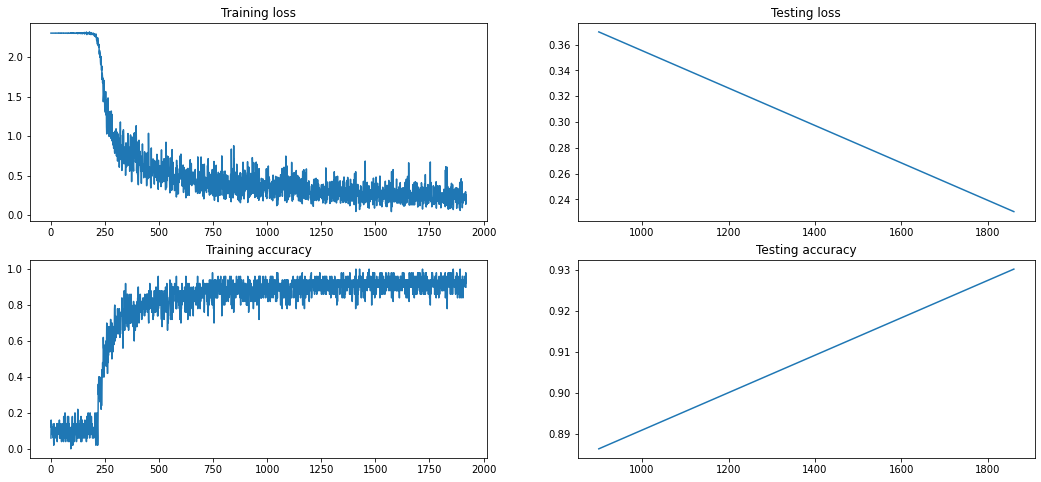

In [5]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

### Train your best MNISTNet!
Tweak the hyperparameters and structure of the MNISTNet. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

The following cell should include your model e.g., `class MyModel` (similar to MNISTNet), the training and validation code. You just need to include the model with the best performance. When you submit, the execution results (output of the cell) should be kept.

In [ ]:
# Implement your new model; and do the training and validation following the previous cell. 
# ...

from nn.layers import *
from nn.model import Model
from nn.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from models.MNISTNet import MNISTNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from data.datasets import MNIST
np.random.seed(5242)

def MyModel():
    conv1_params = {
        'kernel_h': 3,
        'kernel_w': 3,
        'pad': 0,
        'stride': 1,
        'in_channel': 1,
        'out_channel': 10
    }
    conv2_params = {
        'kernel_h': 3,
        'kernel_w': 3,
        'pad': 0,
        'stride': 1,
        'in_channel': 10,
        'out_channel': 24
    }
    pool1_params = {
        'pool_type': 'max',
        'pool_height': 2,
        'pool_width': 2,
        'stride': 2,
        'pad': 0
    }
    pool2_params = {
        'pool_type': 'max',
        'pool_height': 3,
        'pool_width': 3,
        'stride': 2,
        'pad': 0
    }
    model = Model()
    model.add(Conv2D(conv1_params, name='conv1',
                          initializer=Gaussian(std=0.001)))
    model.add(ReLU(name='relu1'))
    model.add(Pool2D(pool1_params, name='pooling1'))
    model.add(Conv2D(conv2_params, name='conv2',
                          initializer=Gaussian(std=0.001)))
    model.add(ReLU(name='relu2'))
    model.add(Pool2D(pool2_params, name='pooling2'))
    # model.add(Dropout(ratio=0.25, name='dropout1'))
    model.add(Flatten(name='flatten'))
    model.add(Linear(600, 256, name='fclayer1',
                      initializer=Gaussian(std=0.01)))
    model.add(ReLU(name='relu3'))
    # model.add(Dropout(ratio=0.5))
    model.add(Linear(256, 10, name='fclayer2',
                      initializer=Gaussian(std=0.01)))
    return model

mnist = MNIST()
mnist.load()
model = MyModel()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.001, decay=0,  sheduler_func=None, bias_correction=True)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)

import time
start = time.time()
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=50, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=-1, test_intervals=900, print_intervals=100)
print('cost:', time.time()-start)

# Your tasks for RNN

### Forward function of lstm operator

In the file [nn/operators.py](nn/operators.py), implement the forward function for `lstm` operation. (`input` is a list of numpy arrays, `[x, c, h]`). 

The following cell test the implementation.

In [1]:
import numpy as np
from tensorflow.keras import layers, Model
from nn.layers import LSTMCell
from utils.tools import rel_error
import numpy
import tensorflow.keras.backend as K


N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
prev_c = np.random.uniform(size=(N, H))

lstm_cell = LSTMCell(in_features=D, units=H)
out,cell = lstm_cell.forward([x, prev_c, prev_h])


#compare with the keras implementation
keras_x = layers.Input(batch_shape=(N, None, D), name='x')
hidden_states = K.variable(value=prev_h)
cell_states = K.variable(value=prev_c)
keras_rnn = layers.LSTM(units=H, use_bias=False, recurrent_activation='sigmoid',stateful=True)(keras_x)
keras_model = Model(inputs=keras_x, 
                          outputs=keras_rnn)
keras_model.layers[1].states[0] = hidden_states
keras_model.layers[1].states[1] = cell_states
keras_model.layers[1].set_weights([lstm_cell.kernel,
                                  lstm_cell.recurrent_kernel])
keras_out = keras_model.predict_on_batch([x[:, None, :]])


print(keras_model.layers[1].get_weights)
#print([a-lstm_cell.kernel,b-lstm_cell.recurrent_kernel])
print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

<bound method Layer.get_weights of <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x0000028F0A4CDB00>>
Relative error (<1e-5 will be fine): 4.3197290213564666e-08


## BiRNN layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of the input data, and concatenating the outputs of the two RNNs. The following function reverses a batch of sequence data  which is necessary for implementing Bi-directional RNN.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

### Backward function of BiRNN layer

Please implement `BiRNN.backward(self, out_grad, input)` in [nn/layers.py](nn/layers.py) and use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [1]:
import numpy as np
from nn.layers import BiRNN
from utils.check_grads_rnn import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
#padding x with a nan mask for testing if the input of backward rnn has been reversed correctly by using _reverse_temporal_data(self, x, mask).
#mask used [[1, 1, 0],[1, 0, 0]]
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BiRNN(in_features=D, units=H, h0=h0, hr=hr)
out_grad = np.random.uniform(size=(N,T,H*2))
check_grads_layer(brnn, x, out_grad)

Gradient to input: correct
Gradient to -:brnn/forward_kernel: correct
Gradient to -:brnn/forward_recurrent_kernel: correct
Gradient to -:brnn/forward_bias: correct
Gradient to -:brnn/backward_kernel: correct
Gradient to -:brnn/backward_recurrent_kernel: correct
Gradient to -:brnn/backward_bias: correct


## Sentiment analysis using RNNs

In this section, you need to implement a RNN model for sentiment analysis. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic model for your experiments, which can be found in [models/SentimentNet.py](models/SentimentNet.py). The architecture is as follow:

```python
Linear(vocab_size, 200, name='embedding')
BiRNN(in_features=200, units=50, initializer=Gaussian(std=0.01))
Linear(100, 32, name='linear1')
TemporalPooling()
Linear(32, 2, name='linear2')
```

The input to the network is a sequence of one-hot vectors, each of which represents a word. The 1st Linear layer works as an embedding layer. After a Bi-directional RNN layer and another Linear layer, a TemporalPooling layer (see `layers.py`) is used to aggregate the vectors into one vector, which skips `NaN`s. The rest of the network is the same as a normal classifier.

In [ ]:
from data import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.01, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

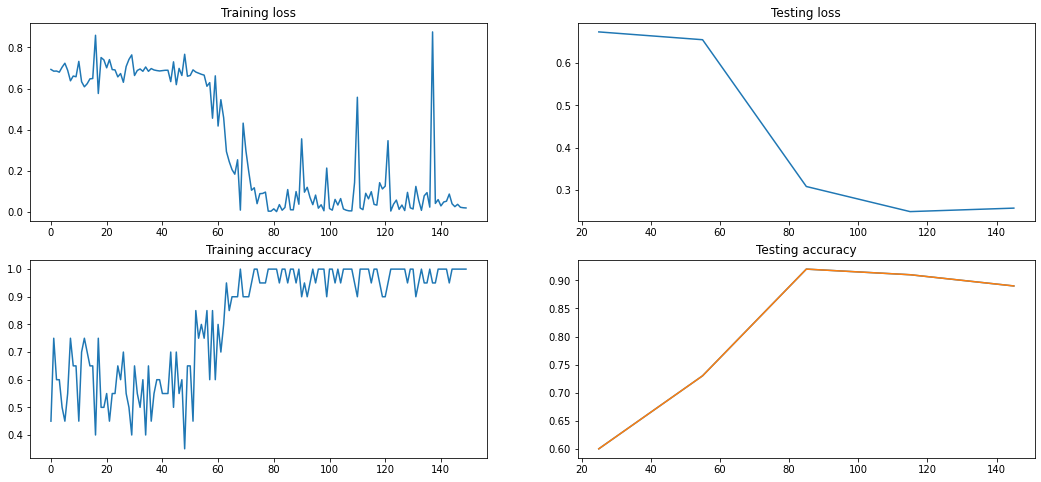

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

### Train your best SentimentNet!

Tweak the hyperparameters and structure of the SentimentNet.

The following cell should include your model e.g., `class MyModel` (similar to SentimentNet), the training and validation code. You just need to include the model with the best performance. When you submit, the execution results (output of the cell) should be kept.

In [14]:
# define your new model and all training codes here, like loading data, defining optimizer and so on

# ...


# Marking Scheme

Marking scheme is shown below:
- 2 marks for `img2col` function
- 1 mark for `conv` backward function
- 2 marks for `pool` forward function
- 2 marks for `lstm` forward function
- 2 marks for `BiRNN` backward function
- 2 marks for tuning your best MNISTNet
- 2 marks for tuning your best SentimentNet
- 1 mark for your submission format
- 1 mark for coding style

We will run multiple test cases to check the correctness of your implementation. You may not get the full marks even if you pass the tests in this notebook as we have a few other test cases for each task, which are not included in this notebook.

For the tuning tasks, please use a fixed random seed (e.g., 0) to make sure the results are reproducible. 

As for submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github. We have offered all materials that you can refer to in this notebook.

## Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 

**ASSIGNMENT DEADLINE: 27 Oct 2020 17:00**

Do not include the `data` folder. Please zip the following folders under a folder named with your NUSNET ID: eg. `a0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment Submission. If unzip the file, the structure should be like this:

```bash
a0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```